# **Step by step process**
- x_train y_train extraction
- get_batch function
- gpt class declaration
    - layers present
        - embedding (vocab,embed)
        - positional embedding (vocab,embed)
        - add them to get x
        - Multi-headed attention(n_heads, head_dim = embed_dim)
            - each_head
                - key(embed, head_size/n_heads), query(embed, head_size/n_heads), value(embed, head_size/n_heads) # (B,T,head_size/n_head)
            - concat in last dimension # (B,T,head_size)
            - linear layer(head_size, vocab_size)
    - forward pass
    - generate/inference
    - training function

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.manual_seed(22)

In [28]:
#text extraction
with open('/Users/sana/Desktop/tmp/input.txt', 'r') as file:
    contents = file.read()
len(contents)

1115394

In [29]:
#train test split in text
train_text, test_text = contents[:int(0.8*len(contents))],contents[int(0.8*len(contents)):]

In [30]:
# vocabulary extraction
vocab = sorted((set(list(contents))))
vocab_size = len(vocab)

In [31]:
# tokenisation unit functions
stoi = {i:idx for idx,i in enumerate(vocab)}
atoi = {idx:i for idx,i in enumerate(vocab)}

In [32]:
# actual tokenisation
tokenize = lambda s: [stoi[i] for i in s]
# tokenize = lambda s: list(map(stoi,s))
de_tokenize = lambda list_of_tokens: "".join([atoi[i] for i in list_of_tokens])

In [33]:
# unit testing for tokenization
tokenize("sana")

[57, 39, 52, 39]

In [34]:
# unit testing for de-tokenization
de_tokenize([57, 39, 52, 39])

'sana'

In [35]:
# Hyper-parameters
lr = 1e-3
context_len = 8
batch_size = 4 
embed_dim = 64
n_batches_to_estimate_loss = 200
n_heads = 4
n_blocks = 6
dropout = 0.2
# n_embed = head_dim//n_heads

In [36]:
# split text_train and text_test in tokens
train_tokens = tokenize(train_text)
test_tokens = tokenize(test_text)

In [37]:
split = ['train','test']

In [38]:
# getting one batch from given text
def get_batch(split, context_len = context_len, batch_size = batch_size):
    list_tokens = train_tokens if split == 'train' else test_tokens
    idx = torch.randint(0,len(list_tokens)-context_len-1,(batch_size,))
    x = torch.stack([torch.tensor(list_tokens[i:i+context_len]) for i in idx])
    y = torch.stack([torch.tensor(list_tokens[i+1:i+context_len+1]) for i in idx])
    return x,y

In [39]:
# unit testing for get_batch
x, y = get_batch('test', 8, 4)

In [40]:
def mean(any_list):
    return sum(any_list)/len(any_list)

In [41]:
class head(nn.Module):
    def __init__(self, head_dim):
        super().__init__()
        # print(f"embed_dim={embed_dim},head_dim={head_dim}")
        # embed_dim = head_dim
        # head_dim = head_dim
        self.key = nn.Linear(embed_dim,head_dim)
        self.value = nn.Linear(embed_dim,head_dim)
        self.query = nn.Linear(embed_dim,head_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        # x --> (B,T,embed_dim)
        T = x.shape[-2]
        key = self.key(x)       # (B,T,head_len)
        query = self.query(x)   # (B,T,head_len)
        value = self.value(x)   # (B,T,head_len)
        attention_weights = query @ key.transpose(-2, -1) * T**(-0.5) # (B,T,T)
        tril = torch.tril(torch.ones((T,T)))  # (T,T)
        causal_attention_weights = attention_weights.masked_fill(tril==0, float('-inf')) # (B,T,T)
        causal_attention_weights = F.softmax(causal_attention_weights, dim = -1) 
        causal_attention_weights = self.dropout(causal_attention_weights)
        new_values = causal_attention_weights @ value   # (B,T,head_len)
        # new_values = F.softmax(new_values, dim = -1)    # (B,T,head_len)
        return new_values   # (B,T,head_len)

        

In [42]:
class Multi_headed_attention(nn.Module):
    def __init__(self, n_head, embed_dim):
        super().__init__()
        each_head_dim = embed_dim//n_head
        self.heads = nn.ModuleList([head(each_head_dim)for _ in range(n_head)])
        self.proj = nn.Linear(n_head*each_head_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        # x --> (B,T, embed_dim)
        # print(self.multi_head[0](x).shape)
        out = torch.cat([single_head(x) for single_head in self.heads],dim=-1) # each_head(x) --> (B,T,head_dim/n_heads)
        # print(f"out.shape ->{out.shape}")
        out = self.dropout(self.proj(out)) #(B,T,embed_dim)
        # print(f"out.shape --> {out.shape}")
        # multi_head_attended_vectors --> (B,T,head_dim)
        return out  # (B,T,embed_dim)
        

In [43]:
a = 0

In [44]:
class FeedForward_NN(nn.Module):
    def __init__(self, n_embed):
        super().__init__()
        self.ff_net = nn.Sequential(
            nn.Linear(n_embed, 4*n_embed),
            nn.ReLU(),
            nn.Linear(4*n_embed, n_embed),
            nn.Dropout(dropout)
        )
    def forward(self,x):
        y = self.ff_net(x) #(B, T, head_dim)
        return y

In [45]:
class Block(nn.Module):
    def __init__(self, n_head, embed_dim):
        super().__init__()
        # head_size = embed_dim//n_head
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.multi_head = Multi_headed_attention(n_head, embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)
        self.ffn = FeedForward_NN(embed_dim)
    def forward(self,x):
        # print(f"x->bef shape{x.shape}")
        # print("a = {a}")
        # a = a + 1
        # print(x.shape)
        x = x + self.multi_head(self.layer_norm1(x)) #(B,T,embed_dim)
        # print(f"x->aft shape{x.shape}")
        x = x + self.ffn(self.layer_norm2(x)) #(B,T,n_embed)
        return x
        


In [46]:
class custom_gpt(nn.Module):
    def __init__(self, embed_dim, vocab_size, context_length):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size,embed_dim)
        self.positional_embedding = nn.Embedding(context_length,embed_dim)
        self.blocks = nn.Sequential(*[Block(n_heads,embed_dim) for _ in range(n_blocks)])
        # self.linear = nn.Linear(embed_dim, vocab_size)
        self.ln_f = nn.LayerNorm(embed_dim) # final layer norm
        self.lm_head = nn.Linear(embed_dim, vocab_size)
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    def forward(self, x, targets=None):
        # x --> (B,T)
        B,T = x.shape
        # x = x[:,-T:,:]s
        token_to_embedding = self.embedding(x) #(B,T,embed_dim)
        # print(f"token_to_embedding : {token_to_embedding.shape}")
        positional_embeddings = self.positional_embedding(torch.tensor([i for i in range(T)])) # (T,embed_dim)
        # print(f"positional_embedding : {positional_embeddings.shape}")
        combined_embeddings = token_to_embedding + positional_embeddings # (B,T,embed_dim)
        # attention_vectors = self.head(combined_embeddings) # (B,T,head_len)
        # print(f"combined embeddings shape : {combined_embeddings.shape}")
        # print(f"n_heads = {n_heads}, head_dim = {head_dim}")
        # multi_headed_attention_vectors = self.mutli_head(combined_embeddings) #(B,T,head_dim)
        out = self.blocks(combined_embeddings)
        # print(f"out shape : {out.shape}")
        out = self.ln_f(out)
        logits = self.lm_head(out)
        # logits = self.linear(multi_headed_attention_vectors) # (B,T,vocab_size)
        loss = None
        if targets is not None:
            B, T, vocab_size = logits.shape
            logits = logits.view(B*T, vocab_size) #(B*T,vocab_size)
            targets = targets.view(B*T) # (B*T,)
            loss = F.cross_entropy(logits, targets)  # loss --> constant
        return logits,loss
        # pass
    
    def train(self, x_train_tokens, n_iterations):
        optimizer = torch.optim.AdamW(self.parameters(), lr = 1e-3)
        # store losses in all iterations to observe the convergence of training
        train_losses = []
        val_losses = []
        for iter in tqdm(range(n_iterations)):
            # x --> (B,T)    targets --> (B,T)
            if iter%500 == 0:
                t,v = self.estimate_loss(n_batches_to_estimate_loss = n_batches_to_estimate_loss)
                train_losses.append(t)
                val_losses.append(v)
            x_train, y_train = get_batch(x_train_tokens, context_len = 8, batch_size = 4)
            _, loss = self(x_train,y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # losses.append(loss.item())
        # plt.plot([i for i in range(len(train_losses))],train_losses)
        plt.plot([i for i in range(len(val_losses))],val_losses)
        plt.xlabel("Iterations")
        plt.ylabel("Validation loss")
    
    @torch.no_grad
    def estimate_loss(self, n_batches_to_estimate_loss):
        losses = dict()
        for split in ['train','test']:
            total_loss = []
            for _ in range(n_batches_to_estimate_loss):
                x, y = get_batch(split,context_len = context_len, batch_size = batch_size)
                _, loss = self(x, y)
                total_loss.append(loss.item())
            losses[split] = mean(total_loss)
        return losses['train'], losses['test']

    @torch.no_grad
    def generate(self,x,num_max_tokens):
        # x --> (B,T)
        T = x.shape[-1]
        for _ in range(num_max_tokens):
            inputs = x[:,-T:] # (B,T)
            logits,_ = self(inputs) # (B,T,vocab_size)
            logits = logits[:,-1,:] # (B,vocab_size)
            # print(logits.shape)
            probs = F.softmax(logits,dim = -1)  # (B,vocab_size)
            # print(probs.shape)
            pred = torch.multinomial(probs, num_samples = 1)    #( B)
            # print(pred.shape)
            # print(x.shape)
            x = torch.cat((x,pred),dim = 1)
            # print(x.shape)
            # return x
        return x

In [47]:
model = custom_gpt(embed_dim, vocab_size = vocab_size, context_length = context_len)

In [48]:
print(model)

custom_gpt(
  (embedding): Embedding(65, 64)
  (positional_embedding): Embedding(8, 64)
  (blocks): Sequential(
    (0): Block(
      (layer_norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (multi_head): Multi_headed_attention(
        (heads): ModuleList(
          (0-3): 4 x head(
            (key): Linear(in_features=64, out_features=16, bias=True)
            (value): Linear(in_features=64, out_features=16, bias=True)
            (query): Linear(in_features=64, out_features=16, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward_NN(
        (ff_net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=Tr

In [49]:
logits, loss = model(x,y)

In [50]:
logits.shape

torch.Size([32, 65])

In [51]:
# check inference of the model before training to generate new_tokens for uncompleted strings
generated_tokens = model.generate(x,100)
generated_strings = [de_tokenize(generated_tokens[i,:].tolist()) for i in range(4)]
generated_strings

['d will nr;QgnfaXhcOSud FVIYobz&!iFRLoapcUD mT:Sz&R:NpC$&\nW&UICQR:zUl ,cfbODGhPryv\nbVKpjw-IOmuBKIMX!ZbwGrwz.j',
 "HIO:\nNowoPrDrUvZzarfHNY'ZqxAxtPh&'U'r:U,fM,MljCAp3d\n:\n&AvR&,&WQwPVrcnMIM&xEPNkVkSDqppogK.gBEDTBksJ.o-whl'?Mx",
 'truth apX?unO3,hhwc Tgql:xKVFDIhrUGLlnvqIEMCSp IJiIXiYUo3MxZYmFvVdGrV$E sJXfXvZ!gfYJEcj.kR?mKRlHfnuX3A;!jzzP',
 'with\ncon;ATqUPDgz-zqCdmDQCDII:uTepH&Qz-YPn:FXJEGTQleAHGbdzULw;GsWAwd dpvUA?Pm!O3mEZp3k Wz-Ohc.sbvQzmGh.QvApQ']

100%|██████████| 100/100 [00:05<00:00, 16.96it/s]


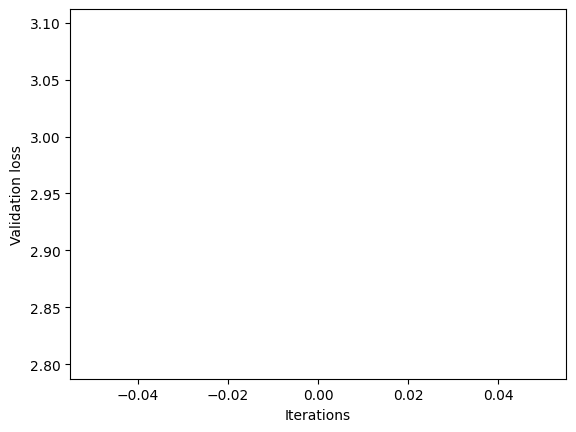

In [53]:
model.train(train_tokens,100)

In [54]:
generated_tokens = model.generate(x,10)
generated_strings = [de_tokenize(generated_tokens[i,:].tolist()) for i in range(batch_size)]
generated_strings

['d will na teo, s h',
 'HIO:\nNow vib sodal',
 'truth ap auad,ed\nU',
 'with\ncon,\nI\n.K\n: n']

In [ ]:
len("d will now or a osteme jase; duch Gowreice ratind efour us; bLUsikn duily wer taninsear hapir.\n\nPROUDIO:\nTo.")

108

In [51]:
a = "a\nt"
print(len(a))
print(a)

3
a
t


In [52]:
for i in a:
    print(i)

a


t
